In [1]:
import os
from os.path import join

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN

data_path = "/media/becode/3D_House/concrete"

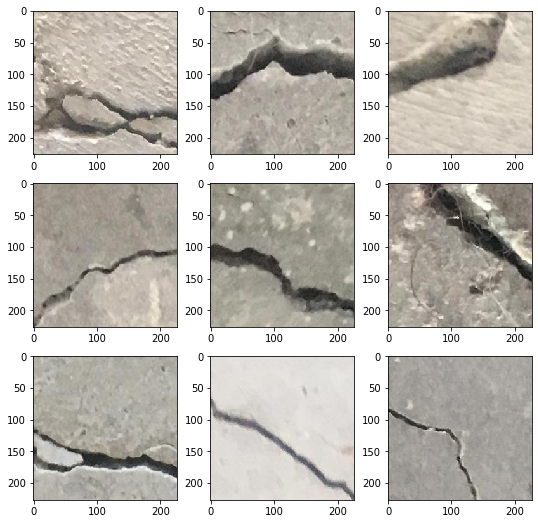

In [2]:


path = join(data_path, "Positive")
fig, ax = plt.subplots(3,3, figsize=(9,9))
for i, file in enumerate(os.listdir(path)[:9]):
    ax[i%3][i//3].imshow(plt.imread(join(path, file)))

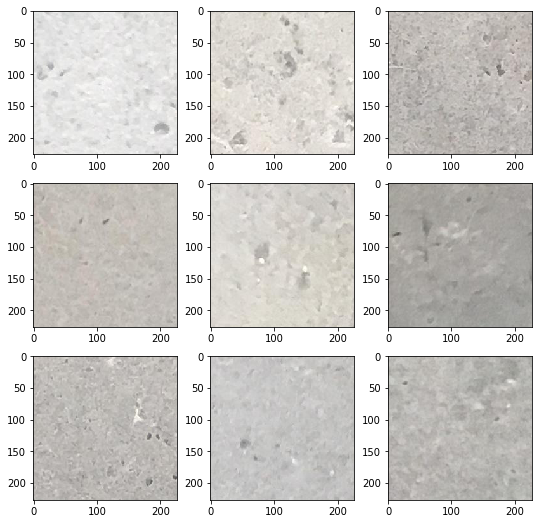

In [3]:
path = join(data_path, "Negative")
fig, ax = plt.subplots(3,3, figsize=(9,9))
for i, file in enumerate(os.listdir(path)[:9]):
    ax[i%3][i//3].imshow(plt.imread(join(path, file)))

In [4]:
import numpy as np
import scipy.ndimage
import scipy.misc
from scipy import ndimage
import argparse

In [5]:
def smooth_gaussian(im, sigma):

    if sigma == 0:
        return im

    im_smooth = im.astype(float)
    kernel_x = np.arange(-3*sigma,3*sigma+1).astype(float)
    kernel_x = np.exp((-(kernel_x**2))/(2*(sigma**2)))

    im_smooth = scipy.ndimage.convolve(im_smooth, kernel_x[np.newaxis])

    im_smooth = scipy.ndimage.convolve(im_smooth, kernel_x[np.newaxis].T)

    return im_smooth


def gradient(im_smooth):

    gradient_x = im_smooth.astype(float)
    gradient_y = im_smooth.astype(float)

    kernel = np.arange(-1,2).astype(float)
    kernel = - kernel / 2

    gradient_x = scipy.ndimage.convolve(gradient_x, kernel[np.newaxis])
    gradient_y = scipy.ndimage.convolve(gradient_y, kernel[np.newaxis].T)

    return gradient_x,gradient_y


def sobel(im_smooth):
    gradient_x = im_smooth.astype(float)
    gradient_y = im_smooth.astype(float)

    kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

    gradient_x = scipy.ndimage.convolve(gradient_x, kernel)
    gradient_y = scipy.ndimage.convolve(gradient_y, kernel.T)

    return gradient_x,gradient_y


def compute_normal_map(gradient_x, gradient_y, intensity=1):

    width = gradient_x.shape[1]
    height = gradient_x.shape[0]
    max_x = np.max(gradient_x)
    max_y = np.max(gradient_y)

    max_value = max_x

    if max_y > max_x:
        max_value = max_y

    normal_map = np.zeros((height, width, 3), dtype=np.float32)

    intensity = 1 / intensity

    strength = max_value / (max_value * intensity)

    normal_map[..., 0] = gradient_x / max_value
    normal_map[..., 1] = gradient_y / max_value
    normal_map[..., 2] = 1 / strength

    norm = np.sqrt(
        np.power(normal_map[..., 0], 2) 
       +np.power(normal_map[..., 1], 2) 
       +np.power(normal_map[..., 2], 2))

    normal_map[..., 0] /= norm
    normal_map[..., 1] /= norm
    normal_map[..., 2] /= norm

    normal_map *= 0.5
    normal_map += 0.5

    return normal_map

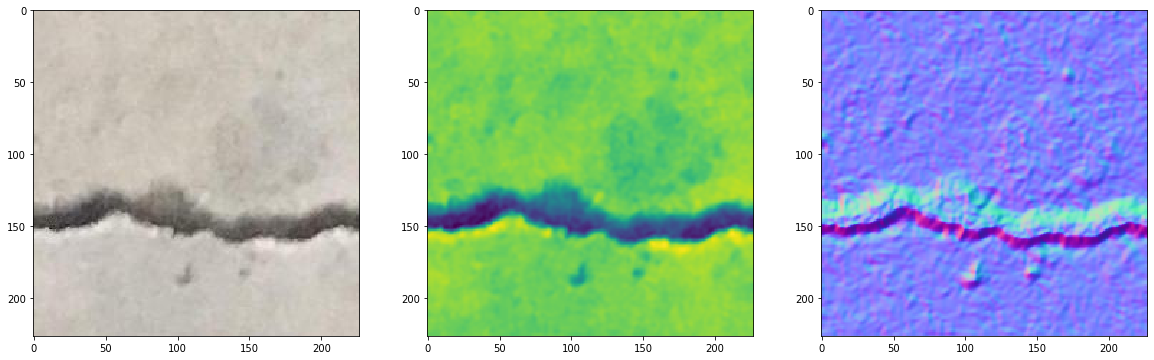

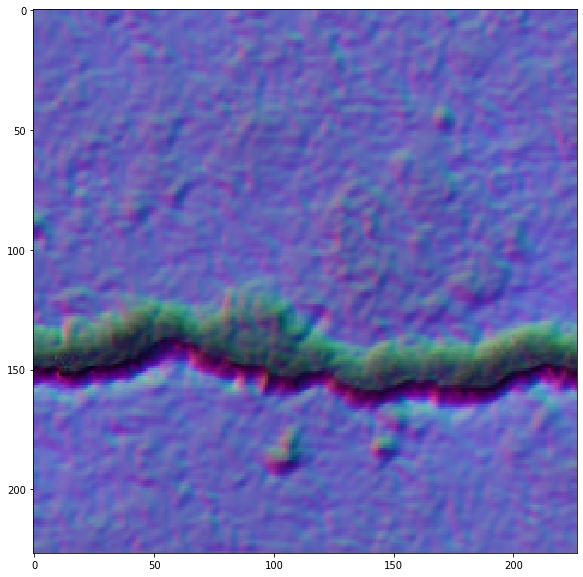

In [217]:
import pandas as pd
file = join(data_path, "Positive", os.listdir(join(data_path, "Positive"))[19])

fig, ax = plt.subplots(ncols=3, figsize=(20,6))
image = plt.imread(file)
im = image
ax[0].imshow(image)

if im.ndim == 3:
    im_grey = np.zeros((im.shape[0],im.shape[1])).astype(float)
    im_grey = (im[...,0] * 0.3 + im[...,1] * 0.6 + im[...,2] * 0.1)
    im = im_grey

im_smooth = smooth_gaussian(im, 1)
ax[1].imshow(im_smooth)

sobel_x, sobel_y = sobel(im_smooth)
normal_map = compute_normal_map(sobel_x, sobel_y, 4)
ax[2].imshow(normal_map)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(np.array(image*normal_map).astype(int))

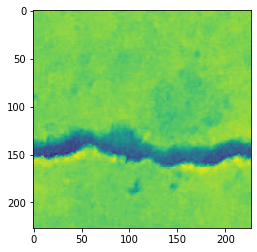

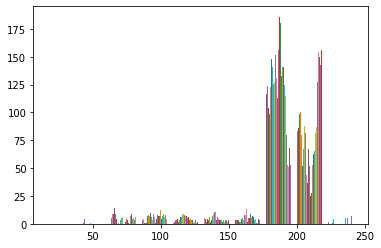

In [218]:
plt.imshow(im_grey)
plt.show()
plt.hist(im_grey)
plt.show()

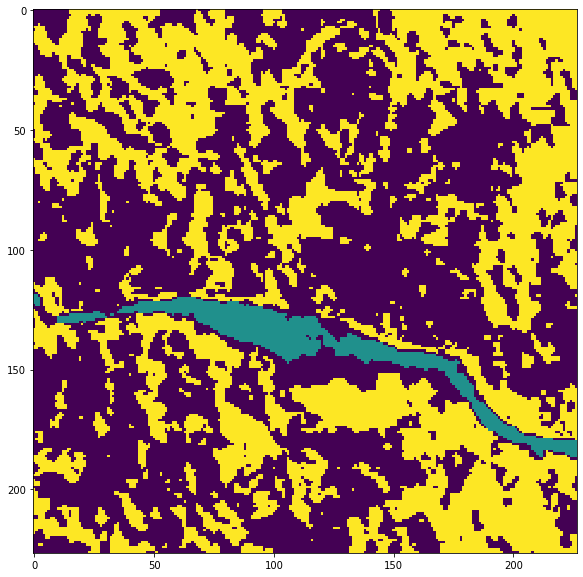

In [243]:
from sklearn.cluster import KMeans

shape = im_grey.shape
kmeans = KMeans(3).fit_predict(im_grey.flatten().reshape(-1,1))
kmeans = kmeans.reshape(shape)
kmeans.shape

plt.figure(figsize=(10,10))
plt.imshow(kmeans)

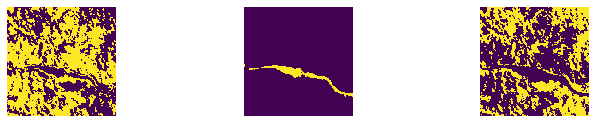

In [245]:
fig, ax = plt.subplots(1, len(np.unique(kmeans)), figsize=(12,2))
[ax.set_axis_off() for ax in ax]

clst_values = []
for i, clst in enumerate(np.unique(kmeans)):
    arr = np.zeros(kmeans.shape)
    arr[kmeans==clst]=1
    ax[i].imshow(arr)
    clst_values.append(arr)

In [221]:
kmeans, flat = kmeans.flatten(), im_grey.flatten()
get_cluster_idxs = lambda kmeans, clst: np.where(kmeans==clst)[0]
clusters = {clst: np.mean(flat[get_cluster_idxs(kmeans, clst)]) for clst in np.unique(kmeans)}
crack = sorted(clusters.items(), key=lambda i:i[1])[0][0]

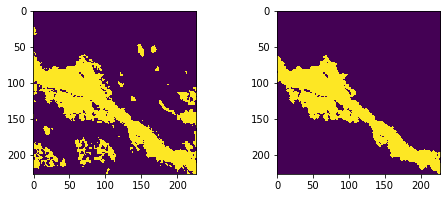

In [262]:
fig, ax = plt.subplots(ncols=2, figsize=(8,3))

main_clst = sorted(zip(*np.unique(kmeans, return_counts=True)), key=lambda i:i[1])[-1][0]

crack_mask = np.ones(im_grey.shape)
crack_mask -= clst_values[main_clst]
ax[0].imshow(crack_mask)

crack_xy = np.array(list(zip(*crack_mask.nonzero())))
crack_dbscan = DBSCAN(eps=1).fit(crack_xy)

main_clst = sorted(zip(*np.unique(crack_dbscan.labels_, return_counts=True)), key=lambda i:i[1])[-1][0]

dbscan_xy = np.array(list(map(lambda x:x[0], 
    filter(lambda x:x[1]==main_clst, zip(crack_xy, crack_dbscan.labels_)))))

test = np.zeros(im_grey.shape)
for idxy in dbscan_xy: test[idxy[0], idxy[1]]=1
ax[1].imshow(test)
plt.show()

In [8]:
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN

data_path = "/media/becode/3D_House/concrete"

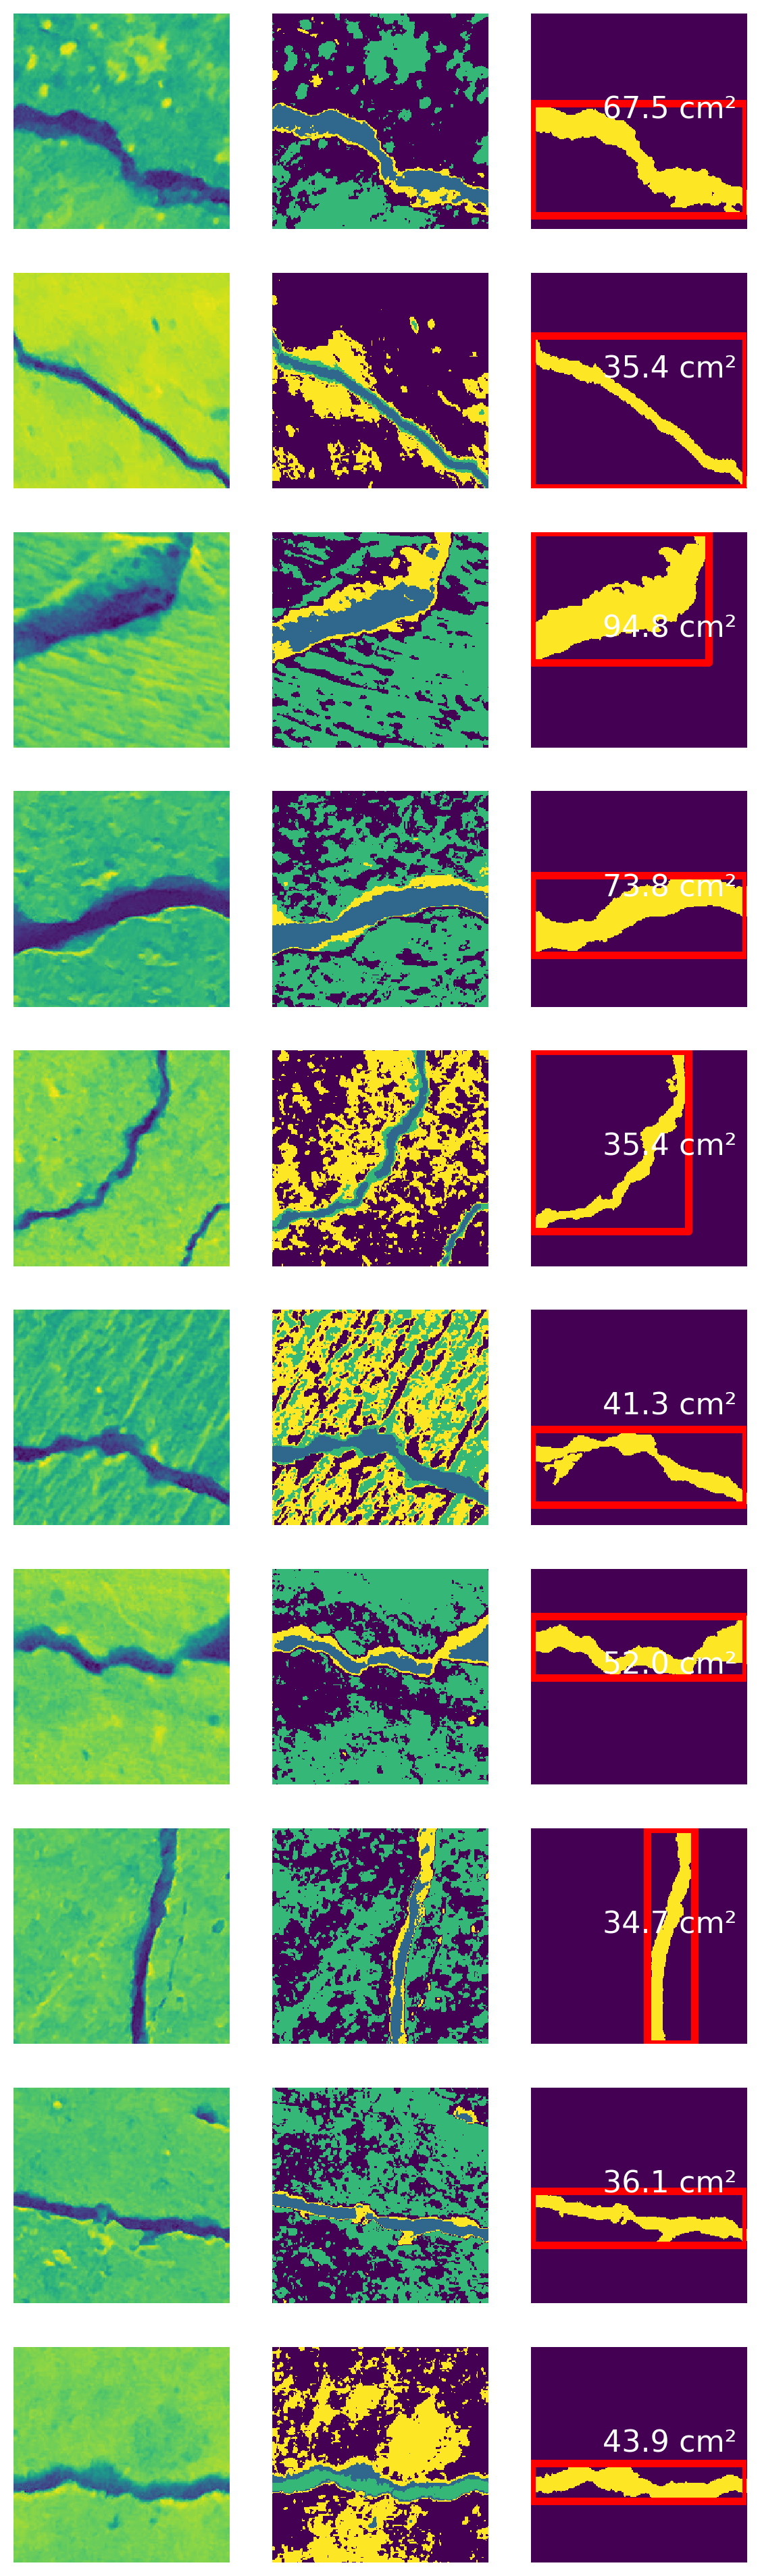

In [10]:
whitelist = [4,5,6,12,13,14,15,17,18,19]
files = os.listdir(join(data_path, "Positive"))[:20]
files = list(map(lambda m: join(data_path, "Positive", m), files))
files = list(filter(lambda m: m[0] in whitelist, enumerate(files)))
files = list(map(lambda m: m[1], files))
files

min_max = lambda arr: (arr.min(), arr.max())
min_rgb = lambda im: [im[...,0].min(),im[...,1].min(),im[...,2].min()]
max_rgb = lambda im: [im[...,0].max(),im[...,1].max(),im[...,2].max()]

rgb_to_grey = lambda im: np.dot(im[... , :3], [.21, .72, .07])

n_images = 10
fig, ax = plt.subplots(n_images, 3, figsize=(7,25), dpi=200)
[ax[i][ii].set_axis_off() for i in range(n_images) for ii in range(3)]

for idx, file in enumerate(files):
    image = rgb_to_grey(plt.imread(join(data_path, "Positive", file)))
    ax[idx][0].imshow(image)
    
    kmeans = KMeans(4).fit_predict(image.flatten().reshape(-1,1)).reshape(image.shape)
    ax[idx][1].imshow(kmeans)
    
    clst_values = []
    for i, clst in enumerate(np.unique(kmeans)):
        arr = np.zeros(kmeans.shape)
        arr[kmeans==clst]=1
        clst_values.append(arr)
         
    kmeans = kmeans.flatten()
    main_clst = np.array(sorted(zip(*np.unique(kmeans, return_counts=True)), key=lambda i:i[1]))[-2:,0]

    crack_mask = np.ones(image.shape)
    for cluster_idxs in main_clst: crack_mask -= clst_values[cluster_idxs]

    crack_xy = np.array(list(zip(*crack_mask.nonzero())))
    crack_dbscan = DBSCAN(eps=1).fit(crack_xy)

    main_clst = sorted(zip(*np.unique(crack_dbscan.labels_, return_counts=True)), key=lambda i:i[1])[-1][0]

    dbscan_xy = np.array(list(map(lambda x:x[0], 
        filter(lambda x:x[1]==main_clst, zip(crack_xy, crack_dbscan.labels_)))))

    result = np.zeros(image.shape)
    for idxy in dbscan_xy: result[idxy[0], idxy[1]]=1
    ax[idx][2].imshow(result)
    
    bounds_x = min_max(np.array(list(zip(*np.nonzero(result))))[:,1])
    bounds_y = min_max(np.array(list(zip(*np.nonzero(result))))[:,0])
    ax[idx][2].plot([bounds_x[0],bounds_x[1],bounds_x[1],bounds_x[0],bounds_x[0]],
        [bounds_y[0],bounds_y[0],bounds_y[1],bounds_y[1],bounds_y[0]],
        c="r", linewidth=4)
    
    surface = result.sum().astype(int)
    ax[idx][2].text(75,110, f"{round(surface/100, 1)} cm²", color="w", fontsize=16)

fig.savefig("/home/becode/Desktop/cracks.png")